# UniKP (logKm)

In [1]:
"""Refer and revise from UniKP https://github.com/Luo-SynBioLab/UniKP with gpl-3.0"""
import os, math
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
current_dir = os.getcwd()
random_state = 66
random.seed(random_state)
np.random.seed(random_state)

def return_scores(y_test, y_pred):
    # 移除 NaN 值
    mask = ~np.isnan(y_test)
    y_test_filtered = y_test[mask]
    y_pred_filtered = y_pred[mask]

    # scores
    rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
    mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
    r2 = r2_score(y_test_filtered, y_pred_filtered)
    pcc = pearsonr(y_test_filtered, y_pred_filtered)

    return rmse, mae, r2, pcc[0]


def return_x_y(df_filtered):
    y = df_filtered[label_name].values
    mask = ~np.isnan(y)

    # factors
    auxiliary_data = []
    if use_t_ph_embedding:
        ph = df_filtered['ph'].values.reshape(-1, 1)
        t = df_filtered['t'].values.reshape(-1, 1)
        auxiliary_data.append(ph)
        auxiliary_data.append(t)

    if use_mw_logp:
        mw = df_filtered['mw'].values.reshape(-1, 1)
        logp = df_filtered['logp'].values.reshape(-1, 1)
        auxiliary_data.append(mw)
        auxiliary_data.append(logp)

    protein_data = np.array(df_filtered[protein_column].tolist())
    substrate_data = np.array(df_filtered[substrate_column].tolist())
    x = np.hstack([protein_data, substrate_data] + auxiliary_data)

    return x[mask], y[mask]

def Smooth_Label(Label_new):
    labels = Label_new
    for i in range(len(labels)):
        labels[i] = labels[i] - min(labels)
    bin_index_per_label = [int(label*10) for label in labels]
    # print(bin_index_per_label)
    Nb = max(bin_index_per_label) + 1
    print(Nb)
    num_samples_of_bins = dict(Counter(bin_index_per_label))
    print(num_samples_of_bins)
    emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]
    print(emp_label_dist, len(emp_label_dist))
    eff_label_dist = []
    beta = 0.9
    for i in range(len(emp_label_dist)):
        eff_label_dist.append((1-math.pow(beta, emp_label_dist[i])) / (1-beta))
    print(eff_label_dist)
    eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
    weights = [np.float32(1 / x) for x in eff_num_per_label]
    weights = np.array(weights)
    print(weights)
    print(len(weights))
    return weights


print('Reading data...', end='')
df_input = pd.read_pickle(f'{current_dir}/../../data_process/dataset/df_all_log_transformed.pkl')
print('Finished.')

# TODO Split dataset
label_name = 'logkm'
use_t_ph_embedding, use_mw_logp = True, True
protein_column, substrate_column = 'prott5', 'molebert'
score_names = ['rmse', 'mae', 'r2', 'pcc']

train_val_idx, test_idx = train_test_split(df_input.index, test_size=0.2, random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
test_x, test_y = return_x_y(df_input.loc[test_idx])

val_scores_list = []
test_scores_list = []
test_pred_list = []
for fold_idx, (train_index, val_index) in enumerate(kf.split(train_val_idx), start=1):
    print(f"Fold: {fold_idx}/5")
    fold_train_idx, fold_val_idx = train_val_idx[train_index], train_val_idx[val_index]
    train_x, train_y = return_x_y(df_input.loc[fold_train_idx])
    val_x, val_y = return_x_y(df_input.loc[fold_val_idx])

    model = ExtraTreesRegressor(n_jobs=-1)
    model.fit(train_x, train_y)

    val_pred = model.predict(val_x)
    val_scores = return_scores(val_y, val_pred)
    test_pred = model.predict(test_x)
    test_pred_list.append(test_pred)
    test_scores = return_scores(test_y, test_pred)

    val_scores_list.append(val_scores)
    test_scores_list.append(test_scores)
    print(f'Val  fold{fold_idx} ', val_scores)
    print(f'Test fold{fold_idx} ', test_scores)

val_scores_mean = np.mean(val_scores_list, axis=0)
test_scores_mean = np.mean(test_scores_list, axis=0)

np.save(f'{current_dir}/results/unikp_test_pred.npy', np.array(test_pred_list))
np.save(f'{current_dir}/results/unikp_test_y.npy', np.array(test_y))

print(f"UniKP with CBW\t RMSE\t MAE\t R2\t PCC\t")
print(f"Val_mean \t {val_scores_mean[0]:.4f} \t {val_scores_mean[1]:.4f} \t {val_scores_mean[2]:.4f} \t {val_scores_mean[3]:.4f}\n"
      f"Test_mean \t {test_scores_mean[0]:.4f} \t {test_scores_mean[1]:.4f} \t {test_scores_mean[2]:.4f} \t {test_scores_mean[3]:.4f}\n")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Reading data...Finished.
Fold: 1/5
Val  fold1  (1.7843249398478633, 1.228320648433084, 0.637566657775463, 0.8011155974443993)
Test fold1  (1.7812817885754608, 1.2261151928121135, 0.6468492870079425, 0.8061059542067075)
Fold: 2/5
Val  fold2  (1.7907995033977666, 1.2291315096124724, 0.6514401225020444, 0.8081582428682699)
Test fold2  (1.7601176448915774, 1.2160695747821029, 0.6551912920228513, 0.8107809798579355)
Fold: 3/5
Val  fold3  (1.7376111900953102, 1.2071837979801494, 0.6552821727520435, 0.8101387790888089)
Test fold3  (1.7663569829234902, 1.2241699182041514, 0.6527423747714317, 0.8091886474066567)
Fold: 4/5
Val  fold4  (1.764318576749076, 1.2285219655921147, 0.6499326857425185, 0.8070541562283756)
Test fold4  (1.7631691617995104, 1.2260636559617608, 0.653994665540194, 0.8098297454433756)
Fold: 5/5
Val  fold5  (1.7727494323094803, 1.224726971491317, 0.6413561669959116, 0.8033390201273306)
Test fold5  (1.756515176071704, 1.2224724440034302, 0.6566013016811008, 0.8115840316913375)
U

# Calculate the mean value of predicted logkm of 5 folds on test dataset

In [2]:
import numpy as np
import os
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

def return_scores(y_test, y_pred):
    # 移除 NaN 值
    mask = ~np.isnan(y_test)
    y_test_filtered = y_test[mask]
    y_pred_filtered = y_pred[mask]

    # scores
    rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
    mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
    r2 = r2_score(y_test_filtered, y_pred_filtered)
    pcc = pearsonr(y_test_filtered, y_pred_filtered)

    return rmse, mae, r2, pcc[0]

current_dir = os.getcwd()
test_pred_list = np.load(f'{current_dir}/results/unikp_test_pred.npy')
test_pred_npy = np.array([np.array(_) for _ in test_pred_list])
logkm_pred_mean = test_pred_npy.mean(axis=0)

logkm_test_y = np.load(f'{current_dir}/results/unikp_test_y.npy')
logkm_scores = return_scores(logkm_test_y, logkm_pred_mean)
logkm_scores

(1.6861969504805132,
 1.1770139987767014,
 0.6835453869569248,
 0.8268480230255317)

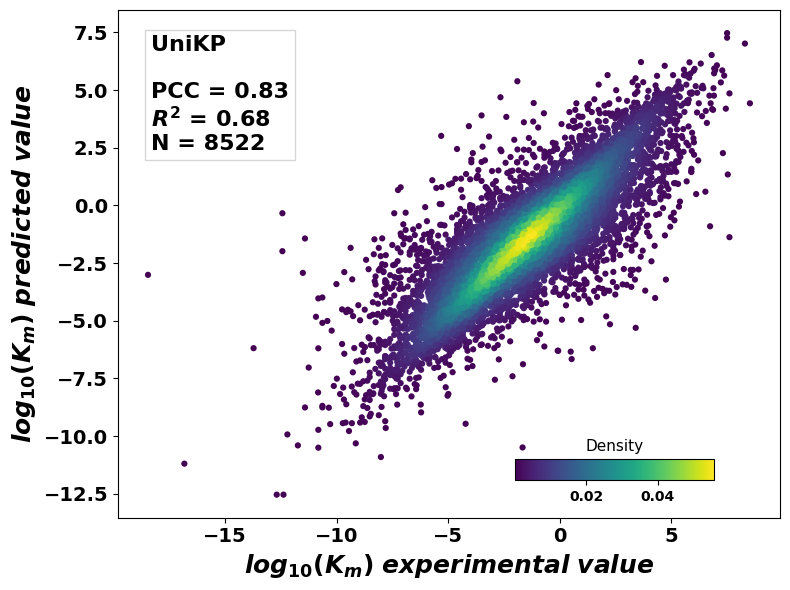

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, gaussian_kde
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc("font", weight="bold")

# 过滤掉填充值
mask = ~np.isnan(logkm_test_y)
logkm_test_y = logkm_test_y[mask]
logkm_pred_mean = logkm_pred_mean[mask]
n = len(logkm_test_y)

# 计算密度
xy = np.vstack([logkm_test_y, logkm_pred_mean])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(
    logkm_test_y,
    logkm_pred_mean,
    c=z,
    s=20,
    cmap='viridis',
    linewidths=0
)

# 在图内底部居中插入一个横向 colorbar
cax = inset_axes(
    ax,
    width="60%",        # 控制宽度百分比
    height="4%",        # 控制高度
    loc='lower center', # 放在图的内部底部中间
    bbox_to_anchor=(0.5, 0.02, 0.5, 1),  # 精细控制位置偏移（可选）
    bbox_transform=ax.transAxes,
    borderpad=2
)

cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
cb.ax.tick_params(labelsize=10)
cb.set_label('Density', fontsize=11, labelpad=6)
cb.ax.xaxis.set_label_position('top')

ax.set_xlabel(r'$log_{10}(K_m)$ $experimental$ $value$', fontsize=18)
ax.set_ylabel(r'$log_{10}(K_m)$ $predicted$ $value$', fontsize=18)
ax.text(
    0.05, 0.95,
    f'UniKP\n\nPCC = {logkm_scores[-1]:.2f}\n$R^2$ = {logkm_scores[-2]:.2f}\nN = {n}',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.9),
    fontsize=16,
    verticalalignment='top'
)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(False)
plt.tight_layout()

plt.savefig(f'{current_dir}/results/unikp_scatter.png')
plt.show()

# Check the data in folds

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import os
import numpy as np
random_state = 66

current_dir = os.getcwd()
df_input = pd.read_pickle(f'{current_dir}/../../data_process/dataset/df_all_log_transformed.pkl')
train_val_idx, test_idx = train_test_split(df_input.index, test_size=0.2, random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

for fold_idx, (train_index, val_index) in enumerate(kf.split(train_val_idx), start=1):
    print(f"Fold: {fold_idx}/5")
    fold_train_idx, fold_val_idx = train_val_idx[train_index], train_val_idx[val_index]
    break

df_input.loc[fold_train_idx].head(20)

Fold: 1/5


,ec,organism,uniprot,substrate,smiles,sequence,type,ph,t,esm2,...,unirep,prott5,prost5,molebert,transsmiles,logkm,logkcat,logkcatkm,logp,mw
2217,1.14.11.21,Streptomyces clavuligerus,,Fe2+,[Fe+2],MASPIVDCTPYRDELLALASELPEVPRADLHGFLDEAKTLAARLPE...,None,7.0,22.0,"[-0.06458024, -0.0010345014, -0.053785775, 0.0...",...,"[0.0075224509999999994, -0.000795085, 0.062706...","[0.034243810900000005, -0.0219621826, -0.01010...","[0.038163363900000004, 0.0277624335, -0.013721...","[0.0271904934, -0.0883065462, -0.1043681651000...","[-0.038277477000000004, -0.2647897303, 0.27698...",-6.265901,NaN,NaN,-0.0025,55.845
36556,1.2.1.24,Rattus norvegicus,,acetaldehyde,CC=O,MATCFLLRNFCAARPALRPPGRLLREPAGAQRRSYVGGPADLHADL...,mutant,7.4,37.0,"[-0.01943562, -0.06248127, 0.043827478, 0.0166...",...,"[0.023190763, 0.14190488, 0.06750115, -0.08053...","[0.0343159735, 0.0528703369, -0.00021097580000...","[0.020247817, -0.026102025100000002, -0.035838...","[0.052422341000000004, -0.2235593796, 0.028691...","[-0.06633460520000001, -0.2557707131, 0.328537...",1.572774,NaN,NaN,0.2052,44.053
10485,2.3.1.74,Medicago sativa,P30074,4-Coumaroyl-CoA,CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=...,MVSVSEIRKAQRAEGPATILAIGTANPANCVEQSTYPDFYFKITNS...,mutant,7.0,25.0,"[0.018932732, -0.042799894, -0.018591547, 0.05...",...,"[0.0042566643, 0.06743560000000001, 0.18864292...","[0.0885761753, 0.1292307675, 0.0534565039, 0.0...","[0.0430424437, -0.023972943400000002, -0.01203...","[-0.0042161415, 0.066334486, -0.0726786628, -0...","[-0.0443507805, -0.1856287271, 0.3006274998000...",-3.571986,-11.358772,-7.824046,0.0837,913.686
31018,4.1.2.49,Aeromonas jandaei,O07051,L-allo-threonine,CC(C(C(=O)O)N)O,MRYIDLRSDTVTQPTDAMRQCMLHAEVGDDVYGEDPGVNALEAYGA...,mutant,8.0,25.0,"[0.07403144, -0.12659568, 0.016762793, -0.0304...",...,"[0.014454099, 0.101328366, 0.118680276, -0.035...","[0.0333200283, 0.033077307, 0.0219806749, 0.00...","[0.0557731427, -0.0465071015, -0.00707134, 0.0...","[0.1900708973, 0.0350804143, 0.100113190700000...","[-0.0652989373, -0.23292773960000002, 0.299708...",0.182322,-0.867501,-1.049822,-1.2209,119.120
14709,2.7.7.30,Homo sapiens,,8-oxoguanosine triphosphate,C(C1C(C(C(O1)N2C3=C(C(=O)NC(=N3)N)NC2=O)O)O)OP...,MRAVRRGLREGGAMAAARDPPEVSLREATQRKLRRFSELRGKLVAR...,None,7.0,37.0,"[-0.0076142913, -0.028555641, -0.020304156, 0....",...,"[0.0023896215, 0.017711587, 0.07126061, -0.020...","[0.0119960103, 0.0063463212, 0.0759175643, 0.0...","[0.0167914964, -0.0019864424, -0.005356404, 0....","[-0.2587032616, 0.0090123862, -0.1322815418, -...","[-0.033287704, -0.16832786800000002, 0.2984947...",-2.755142,0.955511,NaN,-3.0424,539.180
36673,2.6.1.57,Escherichia coli,,L-aspartate,C(C(C(=O)O)N)C(=O)O,MFQKVDAYAGDPILTLMERFKEDPRSDKVNLSIGLYYNEDGIIPQL...,wild,8.0,25.0,"[0.028330974, -0.038229898, 0.0008597843, -0.0...",...,"[0.00747291, -0.017947104, 0.055088967, -0.029...","[0.0531456508, 0.0531576723, 0.037788853000000...","[-0.0923698917, -0.051659993800000005, 0.03883...","[0.038082666700000004, -0.0590877011, 0.410523...","[-0.0584889762, -0.2224599123, 0.2970411777, 0...",1.609438,5.669881,NaN,-1.1270,133.103
17213,3.2.1.85,Staphylococcus aureus,P11175,o-Nitrophenyl beta-D-galactopyranoside 6-phosp...,C1=CC=C(C(=C1)[N+](=O)[O-])OC2C(C(C(C(O2)COP(=...,MTKTLPEDFIFGGATAAYQAEGATNTDGKGRVAWDTYLEENYWYTA...,mutant,7.5,25.0,"[-0.0029190255, -0.056678858, -0.055617426, 0....",...,"[0.0061393943999999995, 0.35437977, 0.11846118...","[0.0239674728, 0.0624862127, 0.0262289606, 0.0...","[-0.0021248932, -0.0047999709000000005, 0.0297...","[-0.1428136975, 0.0402357876, -0.1238845289, 0...","[-0.0354797803, -0.2008396089, 0.2965601981, 0...",-2.302585,-2.813411,-0.579818,-1.1095,381.230
29070,2.7.1.48,Rattus norvegicus,,ATP,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,MAGDSEQTLQNHQQPNGGEPFLIGVSGGTASGKSSVCAKIVQLLGQ...,None,7.6,37.0,"[0.02544611, -0.061939653, -0.022965368, 0.024...",...,"[0.020759622, 0.013959778, 0.13533509, -0.0291...","[0.0540246777, 0.0889646783, 0.0196085516, 0.0...","[